[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\debor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\debor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\debor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\debor\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM Metrics: {'accuracy': 0.44782608695652176, 'f1_score': 0.5000614225821383, 'recall': 0.5017094999418794, 'precision': 0.5594815399426978}


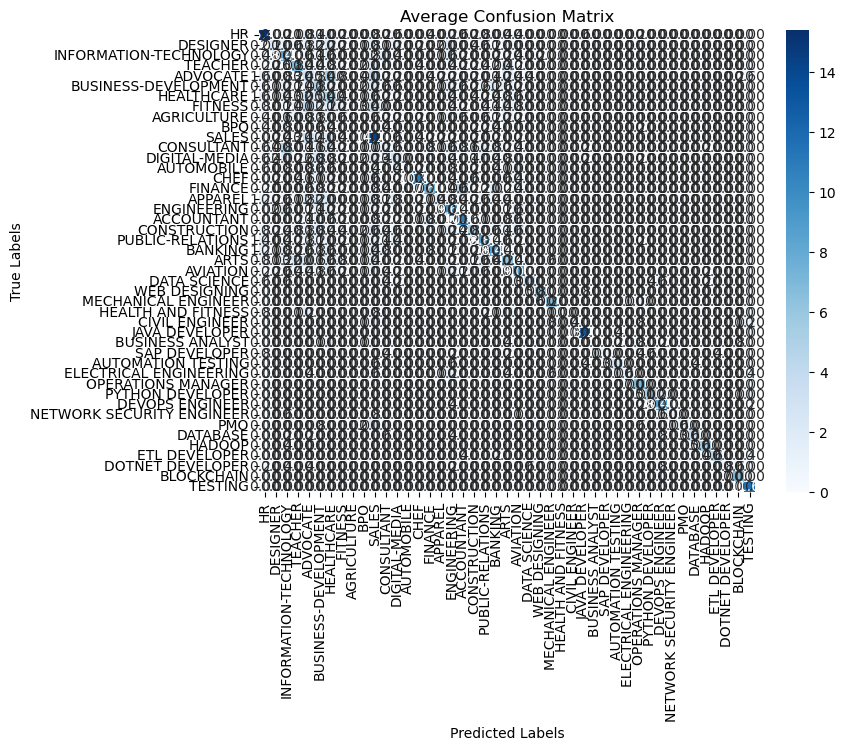

c:\Users\debor\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:06:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\debor\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\debor\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:08:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\debor\anaconda3\Lib\site-packages\

XGBoost Metrics: {'accuracy': 0.4956521739130435, 'f1_score': 0.6242472530494936, 'recall': 0.633952992212657, 'precision': 0.6217693904897542}


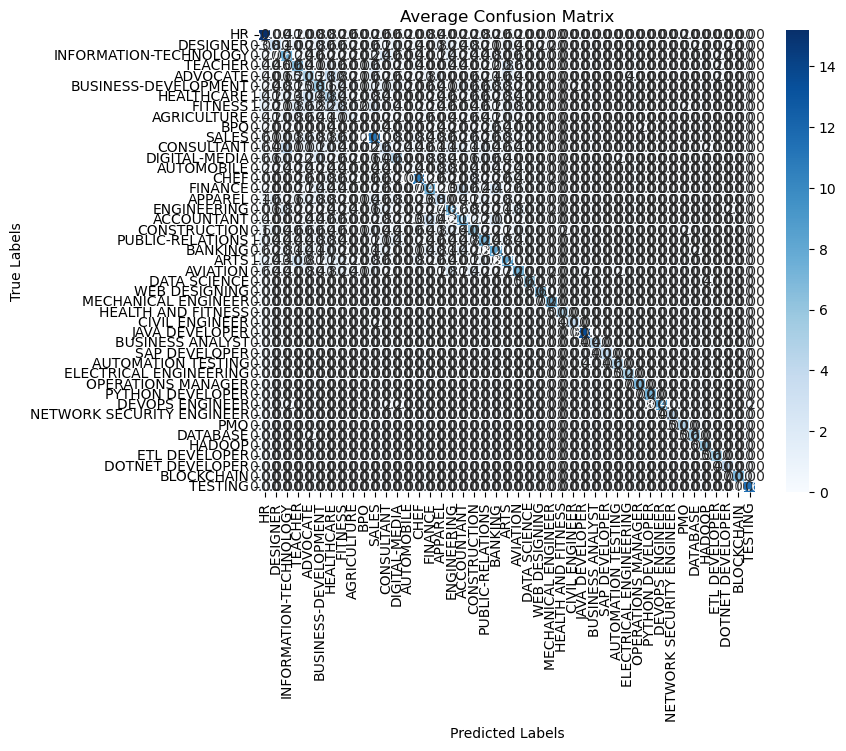

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from xgboost import XGBClassifier
from itertools import product
import re
from transformers import AutoTokenizer, AutoModel
import torch

# Carregar SpaCy modelo
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Carregar os dados de currículos
df_resume = pd.read_csv('./../dados/Resume/Resume.csv')
df_update = pd.read_csv("./../dados/update_resume/UpdatedResumeDataSet.csv")

# Pré-processamento dos dados
df_resume.rename(columns={"Resume_str":"Resume"}, inplace=True, errors='ignore')
df_resume.drop(columns = ['ID', 'Resume_html'], inplace = True, errors='ignore')
df_update["Category"] = df_update.Category.str.upper()

# Concatenar os datasets
df_curr = pd.concat([df_resume, df_update], ignore_index=True)

# Limpeza e tokenização dos currículos
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_words(tokens):
    return [stemmer.stem(word) for word in tokens]

def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

def preprocess(txt):
    txt = txt.lower()
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = re.sub('http\S+\s*', ' ', txt)
    txt = re.sub('RT|cc', ' ', txt)
    txt = re.sub('#\S+', '', txt)
    txt = re.sub('@\S+', '  ', txt)
    txt = re.sub('\s+', ' ', txt)
    txt = nltk.tokenize.word_tokenize(txt)
    txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]
    txt = stem_words(txt)
    txt = lemmatize_words(txt)
    return ' '.join(txt)

df_curr["resume_cleaned"] = df_curr["Resume"].apply(preprocess)

# Extração de entidades nomeadas
def extract_entities(text):
    doc = nlp(text)
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

df_curr['entities'] = df_curr['resume_cleaned'].apply(extract_entities)

# Função para extrair apenas o texto das entidades 
def extract_entity_text(entities):
    return ' '.join([entity[0] for entity in entities])

# Extrair textos das entidades
df_curr['entities_text'] = df_curr['entities'].apply(extract_entity_text)

# Carregar modelo de LLM e Tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def get_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings

# Gerar embeddings para todos os currículos
embeddings = np.vstack(df_curr['entities_text'].apply(get_embeddings).values)

# Criar DataFrame de embeddings
embeddings_df = pd.DataFrame(embeddings)

# Adicionar a coluna de rótulo ao DataFrame de embeddings
target = 'Category'
embeddings_df[target] = df_curr[target].replace({value:num for num,value in enumerate(df_curr[target].unique(),start=0)})

# Classe para Modelagem e Avaliação
class Model_Classification:
    def __init__(self, df, variables, target):
        self.variables = variables
        self.target = target
        self.df = df[variables + [target]]
        self.df_train, self.df_validation = train_test_split(self.df, test_size=0.2, random_state=42)
        self.best_params = None
        self.best_f1 = float('inf')
        self.final_model = None
        self.confusion_matrices = []
        self.num_classes = len(df[target].unique())

    def evaluation_metrics(self, y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        prec = precision_score(y_true, y_pred, average='macro')
        return {'accuracy': acc, 'f1_score': f1, 'recall': rec, 'precision': prec}

    def building_best_model(self, model, param_dist, cv=5):
        X = self.df_train[self.variables]
        y = self.df_train[self.target].values.ravel()

        kf = KFold(n_splits=cv, shuffle=True, random_state=42)
        
        best_f1 = float('-inf')
        best_params = None
        best_model = None

        for params in param_dist:
            model.set_params(**params)
            fold_f1_scores = []

            self.confusion_matrices = []

            for train_index, val_index in kf.split(X):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y[train_index], y[val_index]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
                fold_f1 = f1_score(y_val, y_pred, average='macro')
                fold_f1_scores.append(fold_f1)

                cm = confusion_matrix(y_val, y_pred, labels=range(self.num_classes))
                self.confusion_matrices.append(cm)

            avg_f1 = np.mean(fold_f1_scores)

            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_params = params
                best_model = model

        self.best_params = best_params
        self.final_model = best_model
        self.best_f1 = best_f1
        
        self.final_model.fit(X, y)

    def plot_confusion_matrix(self):
        if not self.confusion_matrices:
            print("No confusion matrices found. Please run building_best_model first.")
            return

        avg_cm = np.mean(self.confusion_matrices, axis=0)
        class_labels = {num: value for num, value in enumerate(df_curr[self.target].unique())}

        plt.figure(figsize=(8, 6))
        sns.heatmap(avg_cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_labels.values(), yticklabels=class_labels.values())
        plt.title('Average Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    def predict(self, new_data):
        if self.final_model is None:
            print("Final model is not trained. Please run train_final_model first.")
            return
        return self.final_model.predict(new_data[self.variables])

variables = embeddings_df.columns.tolist()
variables.remove(target)

# Inicializar e treinar SVM
model_classification = Model_Classification(embeddings_df, variables, target)
svm_param_dist = [
    {'C': 0.1, 'kernel': 'linear'},
    {'C': 1, 'kernel': 'linear'},
    {'C': 10, 'kernel': 'linear'},
    {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'},
    {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}
]
svm_model = SVC()
model_classification.building_best_model(svm_model, svm_param_dist, cv=5)

# Avaliação SVM
svm_predictions = model_classification.predict(model_classification.df_validation)
svm_metrics = model_classification.evaluation_metrics(model_classification.df_validation[target], svm_predictions)
print(f'SVM Metrics: {svm_metrics}')

model_classification.plot_confusion_matrix()

# Inicializar e treinar XGBoost
model_classification_xgb = Model_Classification(embeddings_df, variables, target)
xgb_param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
xgb_param_dist = [dict(zip(xgb_param_grid.keys(), values)) for values in product(*xgb_param_grid.values())]
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model_classification_xgb.building_best_model(xgb_model, xgb_param_dist, cv=5)

# Avaliação XGBoost
xgb_predictions = model_classification_xgb.predict(model_classification_xgb.df_validation)
xgb_metrics = model_classification_xgb.evaluation_metrics(model_classification_xgb.df_validation[target], xgb_predictions)
print(f'XGBoost Metrics: {xgb_metrics}')

model_classification_xgb.plot_confusion_matrix()



In [6]:
from sklearn.model_selection import GridSearchCV

# Definindo o espaço de hiperparâmetros para a busca
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Inicializando o modelo XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Configurando o Grid Search com Cross Validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Treinando o Grid Search no conjunto de treino
X_train = model_classification.df_train[variables]
y_train = model_classification.df_train[target].values.ravel()

grid_search.fit(X_train, y_train)

# Obtendo os melhores hiperparâmetros
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Treinando o modelo final com os melhores hiperparâmetros
best_xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)
best_xgb_model.fit(X_train, y_train)

# Avaliando o modelo final no conjunto de validação
X_val = model_classification.df_validation[variables]
y_val = model_classification.df_validation[target].values.ravel()

xgb_predictions = best_xgb_model.predict(X_val)
xgb_metrics = model_classification.evaluation_metrics(y_val, xgb_predictions)
print(f'XGBoost Metrics after Hyperparameter Tuning: {xgb_metrics}')

model_classification_xgb.final_model = best_xgb_model
model_classification_xgb.plot_confusion_matrix()


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


In [ ]:
from imblearn.over_sampling import SMOTE

# Aplicando SMOTE no conjunto de treino
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Treinando o modelo final com os melhores hiperparâmetros e dados balanceados
best_xgb_model_smote = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)
best_xgb_model_smote.fit(X_train_smote, y_train_smote)

# Avaliando o modelo final no conjunto de validação
xgb_predictions_smote = best_xgb_model_smote.predict(X_val)
xgb_metrics_smote = model_classification.evaluation_metrics(y_val, xgb_predictions_smote)
print(f'XGBoost Metrics after Hyperparameter Tuning and SMOTE: {xgb_metrics_smote}')

model_classification_xgb.final_model = best_xgb_model_smote
model_classification_xgb.plot_confusion_matrix()


In [ ]:
from sklearn.ensemble import VotingClassifier

# Inicializando os modelos base
svm_model = SVC(C=1, kernel='linear', probability=True)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)

# Combinando os modelos com Voting Classifier
voting_clf = VotingClassifier(estimators=[('svm', svm_model), ('xgb', xgb_model)], voting='soft')
voting_clf.fit(X_train, y_train)

# Avaliando o modelo final no conjunto de validação
voting_predictions = voting_clf.predict(X_val)
voting_metrics = model_classification.evaluation_metrics(y_val, voting_predictions)
print(f'Voting Classifier Metrics: {voting_metrics}')

model_classification_xgb.final_model = voting_clf
model_classification_xgb.plot_confusion_matrix()


In [ ]:
# Inicializar e treinar modelos e avaliar métricas
model_classification_xgb = Model_Classification(embeddings_df, variables, target)

# Inicializar e treinar modelo XGBoost sem SMOTE
model_classification_xgb.building_best_model(xgb_model, xgb_param_dist, cv=5)
xgb_predictions = model_classification_xgb.predict(model_classification_xgb.df_validation)
xgb_metrics = model_classification_xgb.evaluation_metrics(model_classification_xgb.df_validation[target], xgb_predictions)

# Inicializar e treinar modelo XGBoost com SMOTE
model_classification_xgb_smote = Model_Classification(embeddings_df, variables, target)
model_classification_xgb_smote.building_best_model(best_xgb_model_smote, xgb_param_dist, cv=5)
xgb_predictions_smote = model_classification_xgb_smote.predict(model_classification_xgb_smote.df_validation)
xgb_metrics_smote = model_classification_xgb_smote.evaluation_metrics(model_classification_xgb_smote.df_validation[target], xgb_predictions_smote)

# Inicializar e treinar Voting Classifier
model_classification_voting = Model_Classification(embeddings_df, variables, target)
model_classification_voting.building_best_model(voting_clf, svm_param_dist + xgb_param_dist, cv=5)
voting_predictions = model_classification_voting.predict(model_classification_voting.df_validation)
voting_metrics = model_classification_voting.evaluation_metrics(model_classification_voting.df_validation[target], voting_predictions)

# Comparação das métricas
print(f'XGBoost Metrics: {xgb_metrics}')
print(f'XGBoost Metrics with SMOTE: {xgb_metrics_smote}')
print(f'Voting Classifier Metrics: {voting_metrics}')

# Plotar matrizes de confusão
model_classification_xgb.plot_confusion_matrix()
model_classification_xgb_smote.plot_confusion_matrix()
model_classification_voting.plot_confusion_matrix()
